In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy
%matplotlib inline

In [18]:
import warnings
warnings.filterwarnings('ignore')

# Data

In [8]:
df = pd.read_csv("bioresponse.csv")
X = df.drop(["Activity"], axis=1)
y = df[["Activity"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 42)

# Getting functions

In [4]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

# optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    
    for i in range(num_iterations):
                
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

# Logistic regression

In [82]:
max_iter = 1000
w, b = np.zeros((X_train.shape[1], 1)), 0
lr = 0.015

In [107]:
params_lr, grads_lr, costs_lr = optimize(w, b, X_train.T, y_train.values.reshape(1, -1), max_iter, lr, print_cost = True)

Cost after iteration 0: 0.485556
Cost after iteration 100: 0.480607
Cost after iteration 200: 0.476278
Cost after iteration 300: 0.472375
Cost after iteration 400: 0.468828
Cost after iteration 500: 0.465579
Cost after iteration 600: 0.462586
Cost after iteration 700: 0.459812
Cost after iteration 800: 0.457229
Cost after iteration 900: 0.454812


In [23]:
w = params["w"]
b = params["b"]

In [27]:
pred = (np.dot(w.T, X_test.T) + b > 0.5) * 1

In [41]:
print("Accuracy: ", round(accuracy_score(y_test.values.reshape(1, -1)[0], pred[0]) * 100, 2), "%")

Accuracy:  73.45 %


# SGD

In [70]:
def sgd(w, b, X, y, max_iter, lr, batch_size, print_cost=False):
    costs = []
    m = X.shape[1]
    
    for i in range(max_iter):
        permutation = np.random.permutation(m)
        permuted_X = X.values[:, permutation]
        permuted_y = y[:, permutation]
        
        for j in range(0, m, batch_size):
            X_batch = permuted_X[:, j:j+batch_size]
            y_batch = permuted_y[:, j:j+batch_size]
            grads, cost = propagate(w, b, X_batch, y_batch)
            dw = grads["dw"]
            db = grads["db"]
            w -= lr * dw
            b -= lr * db
            
        if i % 100 == 0:
            costs.append(cost)
            
            if print_cost:
                print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w, 
              "b": b}
    
    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [43]:
def adam(w, b, X, Y, max_iter, lr, beta1=0.9, beta2=0.999, epsilon=1e-8, print_cost=False):
    costs = []
    m = X.shape[1]
    
    vdw, vdb = 0, 0
    sdw, sdb = 0, 0

    for i in range(max_iter):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        
        vdw = beta1 * vdw + (1 - beta1) * dw
        vdb = beta1 * vdb + (1 - beta1) * db
        sdw = beta2 * sdw + (1 - beta2) * (dw**2)
        sdb = beta2 * sdb + (1 - beta2) * (db**2)
        
        vdw_corrected = vdw / (1 - beta1**(i + 1))
        vdb_corrected = vdb / (1 - beta1**(i + 1))
        sdw_corrected = sdw / (1 - beta2**(i + 1))
        sdb_corrected = sdb / (1 - beta2**(i + 1))
        
        w -= lr * vdw_corrected / (np.sqrt(sdw_corrected) + epsilon)
        b -= lr * vdb_corrected / (np.sqrt(sdb_corrected) + epsilon)

        if i % 100 == 0:
            costs.append(cost)
            
            if print_cost:
                print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}

    return params, grads, costs

# Applying

In [71]:
batch_size=64
w = np.zeros((X_train.shape[1], 1))
b = 0

In [72]:
params_sgd, grads_sgd, costs_sgd = sgd(w, b, X_train.T, y_train.values.reshape(1, -1), max_iter, lr, batch_size, print_cost=True)

Cost after iteration 0: 0.657371
Cost after iteration 100: 0.395910
Cost after iteration 200: 0.471244
Cost after iteration 300: 0.262014
Cost after iteration 400: 0.340890
Cost after iteration 500: 0.467107
Cost after iteration 600: 0.331397
Cost after iteration 700: 0.335963
Cost after iteration 800: 0.335392
Cost after iteration 900: 0.431556


In [77]:
batch_size=64
w = np.zeros((X_train.shape[1], 1))
b = 0

In [78]:
params_adam, grads_adam, costs_adam = adam(w, b, X_train.T, y_train.values.reshape(1, -1), max_iter, lr, beta1=0.9, beta2=0.999, epsilon=1**(-8), print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.615901
Cost after iteration 200: 0.579360
Cost after iteration 300: 0.555599
Cost after iteration 400: 0.538360
Cost after iteration 500: 0.525081
Cost after iteration 600: 0.514441
Cost after iteration 700: 0.505663
Cost after iteration 800: 0.498254
Cost after iteration 900: 0.491886


# Visualisation

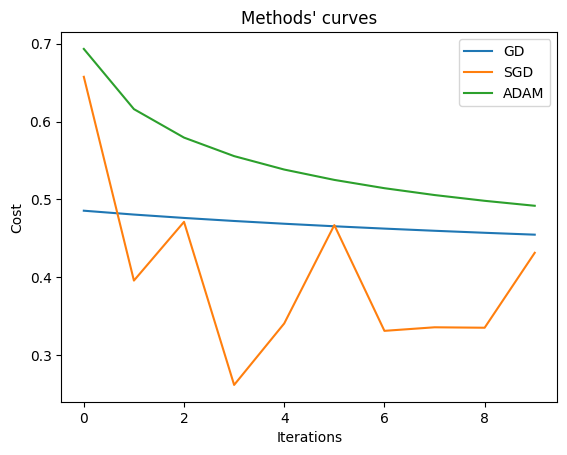

In [108]:
plt.plot(costs_lr, label="GD")
plt.plot(costs_sgd, label="SGD")
plt.plot(costs_adam, label="ADAM")
plt.title("Methods' curves")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()

# Different learning rates

In [113]:
learning_rates_list = [10**(-i) for i in range(1, 6)]
max_iter = 1000

models = dict()
costs = dict()

In [115]:
for lr in learning_rates_list:
    w, b = np.zeros((X_train.shape[1], 1)), 0
    
    temp_params, _, temp_costs = optimize(w, b, X_train.T, y_train.values.reshape(1, -1), max_iter, lr)
    
    models[f"LR_{lr}"] = temp_params
    costs[f"LR_{lr}"] = temp_costs
    
    w, b = np.zeros((X_train.shape[1], 1)), 0
    
    temp_params, _, temp_costs = sgd(w, b, X_train.T, y_train.values.reshape(1, -1), max_iter, lr, batch_size)
    
    models[f"SGD_{lr}"] = temp_params
    costs[f"SGD_{lr}"] = temp_costs
    
    w, b = np.zeros((X_train.shape[1], 1)), 0
    
    temp_params, _, temp_costs = adam(w, b, X_train.T, y_train.values.reshape(1, -1), max_iter, lr, beta1=0.9, beta2=0.999, epsilon=1**(-8))
    
    models[f"ADAM_{lr}"] = temp_params
    costs[f"ADAM_{lr}"] = temp_costs
    
    print(f"{lr} is ready")

0.1 is ready
0.01 is ready
0.001 is ready
0.0001 is ready
1e-05 is ready


In [139]:
best_model = ''
best_accuracy = 0

for model_name, model_params in models.items():
    w = model_params["w"]
    b = model_params["b"]
    
    pred_proba = np.dot(w.T, X_test.T) + b
    pred = ((pred_proba > 0.5) * 1)[0]
    accuracy = round(accuracy_score(y_test, pred) * 100, 2)
    
    name, lr = model_name.split("_")
    
    print(f"Model {name} with learning rate {lr} has accuracy {accuracy} on test data")
    
    if accuracy > best_accuracy:
        best_model = model_name
        best_accuracy = accuracy
        
    print("---------------------------")
    
    
print()
name, lr = best_model.split("_")
print(f"The best model is {name} with learning rate {lr} and accuracy {best_accuracy}")

Model LR with learning rate 0.1 has accuracy 74.63 on test data
---------------------------
Model SGD with learning rate 0.1 has accuracy 73.03 on test data
---------------------------
Model ADAM with learning rate 0.1 has accuracy 74.73 on test data
---------------------------
Model LR with learning rate 0.01 has accuracy 70.58 on test data
---------------------------
Model SGD with learning rate 0.01 has accuracy 74.2 on test data
---------------------------
Model ADAM with learning rate 0.01 has accuracy 70.36 on test data
---------------------------
Model LR with learning rate 0.001 has accuracy 55.86 on test data
---------------------------
Model SGD with learning rate 0.001 has accuracy 73.35 on test data
---------------------------
Model ADAM with learning rate 0.001 has accuracy 55.54 on test data
---------------------------
Model LR with learning rate 0.0001 has accuracy 42.96 on test data
---------------------------
Model SGD with learning rate 0.0001 has accuracy 65.03 on te